In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
if not os.path.exists('./plots/'):
    os.makedirs('./plots/empirical')
    os.makedirs('./plots/ours/ranking')
    os.makedirs('./plots/ours/aggregation')
    os.makedirs('./plots/ours/thresholding')

sns.set_style('white')
# add in PLT params here

model_names = ['resnet18', 'resnet50', 'resnet101', 'MobileNetV2']
model_name_dict = {'resnet101':'ResNet-101', 'resnet18':'ResNet-18', 'MobileNetV2':'MobileNetV2',
                   'resnet50':'ResNet-50'}
aug_names = ['combo', 'hflip', 'rotation', 'colorjitter', 'fivecrop', 'orig']

In [12]:
# Single augmentation accuracy comparison
results = pd.concat([pd.read_csv('./results/resnet50_agg_fs'),
                     pd.read_csv('./results/resnet101_agg_fs'),
                     pd.read_csv('./results/resnet18_agg_fs'),
                     pd.read_csv('./results/MobileNetV2_agg_fs')])
orig_accs = results[(results['aug'] == 'orig') & (results['agg']=='mean')]
def get_diff_top1(row):
    top1_orig_acc = orig_accs[orig_accs['model'] == row['model']]['top1'].values[0]
    return row['top1'] - top1_orig_acc
def get_diff_top5(row):
    top5_orig_acc = orig_accs[orig_accs['model'] == row['model']]['top5'].values[0]
    return row['top5'] - top5_orig_acc
results['top1_diff'] = results.apply(get_diff_top1, axis=1)
results['top5_diff'] = results.apply(get_diff_top5, axis=1)

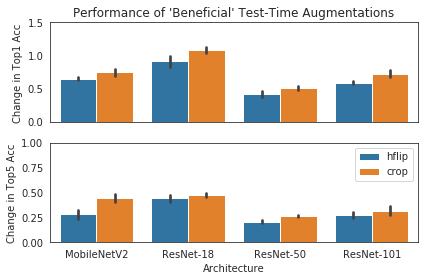

In [13]:
# single augmentation; grouped bar chart of differences between original accuracy vs augmentation 
model_order = ["MobileNetV2", "resnet18", "resnet50", "resnet101"]
aug_order = ['hflip', 'five_crop']
mean_results = results[(results['agg'] == 'mean') & (results['aug'] != 'orig')]
good_mean_results = mean_results[mean_results['aug'].isin(aug_order)]
fig, axs = plt.subplots(nrows=2, squeeze=False)
axs = axs.flatten()
sns.barplot(x='model', y='top1_diff', hue='aug', data=good_mean_results, ax=axs[0],
            hue_order=aug_order, order=model_order)
sns.barplot(x='model', y='top5_diff', hue='aug', data=good_mean_results, ax=axs[1],
            hue_order=aug_order, order=model_order)

axs[0].get_legend().set_visible(False)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].set_ylim(0, 1.5)
axs[0].set_ylabel('Change in Top1 Acc')
axs[0].set_title("Performance of 'Beneficial' Test-Time Augmentations")
axs[1].get_legend().set_visible(False)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Change in Top5 Acc')
axs[1].set_xlabel('Architecture')
axs[1].set_xticklabels(['MobileNetV2', 'ResNet-18', 'ResNet-50', 'ResNet-101'])

#axs[1].set_xtick_labels(['MobileNetV2', 'Resnet18', 'ResNet50', 'ResNet101'])

handles, labels = axs[1].get_legend_handles_labels()
labels = ['hflip', 'crop']
axs[1].legend(handles, labels, loc='upper right')
plt.subplots_adjust(left=.1)
plt.tight_layout()
plt.savefig('./figs/partI/standard_aug_good.pdf', filetype='pdf', bbox_inches='tight')

In [31]:
model_name = 'MobileNetV2'
aug_name = 'combo'
print(np.std(results[(results['model'] == model_name) 
                & (results['aug'] == aug_name) 
                & (results['agg'] == 'partial_lr') ]['top1_diff']))
print(np.mean(results[(results['model'] == model_name) 
                & (results['aug'] == aug_name) 
                & (results['agg'] == 'partial_lr') ]['top1_diff']))

0.06207991628105765
1.0761088709677353


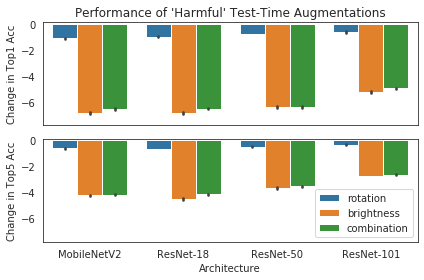

In [15]:
# single augmentation; grouped bar chart of differences between original accuracy vs augmentation 
sns.set_style('white')
model_order = ["MobileNetV2", "resnet18", "resnet50", "resnet101"]
bad_aug_order = ['rotation', 'colorjitter', 'combo']
mean_results = results[(results['agg'] == 'mean') & (results['aug'] != 'orig')]
bad_mean_results = mean_results[mean_results['aug'].isin(bad_aug_order)]
fig, axs = plt.subplots(nrows=2, squeeze=False)
axs = axs.flatten()
sns.barplot(x='model', y='top1_diff', hue='aug', data=bad_mean_results, ax=axs[0],
            hue_order=bad_aug_order, order=model_order)
sns.barplot(x='model', y='top5_diff', hue='aug', data=bad_mean_results, ax=axs[1],
            hue_order=bad_aug_order, order=model_order)

axs[0].get_legend().set_visible(False)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].set_ylim(-7.8, .1)
axs[0].set_ylabel('Change in Top1 Acc')
axs[0].set_title("Performance of 'Harmful' Test-Time Augmentations")
axs[1].get_legend().set_visible(False)
axs[1].set_ylim(-7.8, .1)
axs[1].set_ylabel('Change in Top5 Acc')
axs[1].set_xlabel('Architecture')
axs[1].set_xticklabels(['MobileNetV2', 'ResNet-18', 'ResNet-50', 'ResNet-101'])
handles, labels = axs[1].get_legend_handles_labels()
labels=['rotation', 'brightness', 'combination']
axs[1].legend(handles, labels, loc='lower right')
#plt.subplots_adjust(left=.05)
plt.tight_layout()
plt.savefig('./figs/partI/standard_aug_bad.pdf', filetype='pdf', bbox_inches='tight')

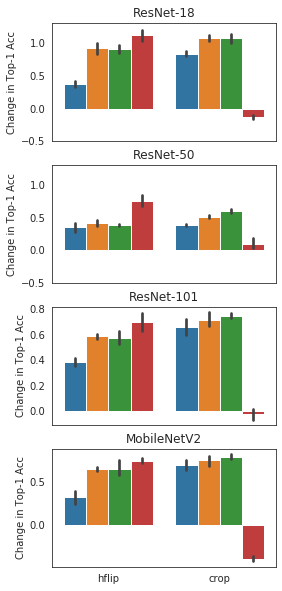

In [16]:
import numpy as np

good_augs = ['hflip', 'five_crop']
good_augs_labels = ['hflip', 'crop']
bad_augs = ['rotation', 'colorjitter', 'combo']
bad_augs_labels = ['rotation', 'brightness', 'combination']
hue_order = ['max', 'mean', 'partial_lr', 'full_lr']
mode = 'good'
fig, axs = plt.subplots(nrows=4, squeeze=False, figsize=(4, 10))
axs = axs.flatten()
# add a little bit so that the bars render
for i, model_name in enumerate(model_names):

    if mode == 'good':
        aug_order = good_augs
        x_labels = good_augs_labels
    else:
        aug_order = bad_augs
        x_labels = bad_augs_labels
    one_resnet = results[(results['model'] == model_name) & (results['aug'] != 'orig')]
    one_resnet = one_resnet[one_resnet['aug'].isin(aug_order)]
    # add a little bit so the bar renders and represent it in the table
    delta = .3

    orig_val = one_resnet[#(one_resnet['model'] == 'MobileNetV2') &
                     (one_resnet['aug'].isin(['rotation', 'colorjitter'])) &
                     (one_resnet['agg'] == 'partial_lr')]['top1_diff']
    if len(orig_val):

        one_resnet.loc[#(one_resnet['model'] == 'MobileNetV2') &
                         (one_resnet['aug'].isin(['rotation', 'colorjitter'])) &
                         (one_resnet['agg'] == 'partial_lr'), ['top1_diff']] = orig_val + np.sign(orig_val + 1e-4) * delta
    new_val = one_resnet[#(one_resnet['model'] == 'MobileNetV2') &
                     (one_resnet['aug'].isin(['rotation', 'colorjitter'])) & 
                     (one_resnet['agg'] == 'partial_lr')]['top1_diff']

    sns.barplot(x='aug', y='top1_diff', hue='agg', data=one_resnet, ax=axs[i],
                order=aug_order, hue_order=hue_order)

    axs[i].set_title(model_name_dict[model_name])
    axs[i].set_ylabel('Change in Top-1 Acc')
    axs[i].get_legend().set_visible(False)
    axs[i].set_xlabel('')
    if i != 3:
        axs[i].set_xticklabels('')
    else:
        axs[i].set_xticklabels(x_labels)

    #axs[1].set_ylabel('Change in Top5 Acc')
    
    if mode == 'good':
        axs[0].set_ylim(-.5, 1.3)
        axs[1].set_ylim(-.5, 1.3)
    else:
        axs[0].set_ylim(-20, 2)
        axs[1].set_ylim(-20, 2)
if mode == 'bad':
    handles, labels = axs[3].get_legend_handles_labels()
    labels = [ 'Max', 'Mean', 'Partial-LR', 'Full-LR']
    axs[3].legend(handles, labels, loc='lower left')
plt.savefig('./figs/partII/agg_comparison_' + mode +'.pdf', filetype='pdf', bbox_inches='tight')

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



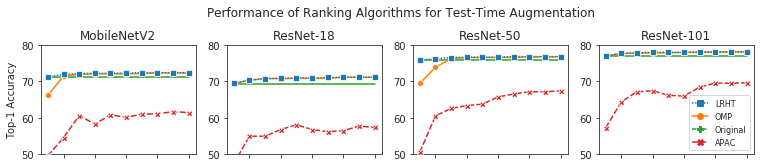

In [20]:
# Ranking plots
sns.set_style('ticks')
model_name = 'resnet18'
model_names = ['MobileNetV2', 'resnet18', 'resnet50', 'resnet101']
fig, axs = plt.subplots(ncols=4, squeeze=False, figsize=(10, 2))
axs = axs.flatten()
with_APAC = 'with_APAC'
if with_APAC == 'with_APAC':
    fig.suptitle('Performance of Ranking Algorithms for Test-Time Augmentation', y=1.15)

for i,model_name in enumerate(model_names):
    ranking = pd.read_csv('./results/' + model_name + '_ranking_fs')
    orig_top1 = results[(results['agg'] == 'mean') & (results['aug'] == 'orig') 
                          &(results['model'] == model_name)]['top1'].values[0]
    orig_top5 = results[(results['agg'] == 'mean') & (results['aug'] == 'orig') 
                          &(results['model'] == model_name)]['top5'].values[0]
    dicts_to_add = [{'top1': orig_top1, 'top5': orig_top5, 'model': model_name, 
                     'rank': 'orig', 'n_augs': i+1} for i in range(10)]
    ranking = pd.concat([ranking, pd.DataFrame(dicts_to_add)])
    hue_order = ['LR', 'OMP', 'orig', 'APAC', ]
    legend_order = ['', 'LRHT', 'OMP','Original',  'APAC']
    if with_APAC != 'with_APAC':
        ranking = ranking[ranking['rank'] != 'APAC']
        hue_order = ['LR', 'OMP', 'orig']
        legend_order = ['', 'LRHT', 'OMP', 'Original']
    
    sns.lineplot(x='n_augs',y='top1', hue='rank', style='rank',data=ranking, 
                 hue_order=hue_order, markers=True, ax=axs[i])
    
    axs[i].lines[2].set_marker(None)
    axs[i].lines[2].set_linestyle('-')
    axs[i].set_xlabel('# of Augmentations')
    axs[i].set_title(model_name_dict[model_name])
    axs[i].get_legend().set_visible(False)
    if with_APAC == 'with_APAC':
        axs[i].set_ylim(50, 80)
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')


    if i != 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('Top-1 Accuracy')
    if i == 3 and with_APAC == 'with_APAC':
        handles, labels = axs[i].get_legend_handles_labels()
        labels = legend_order
        axs[i].legend(handles[1:], labels[1:], loc='lower right', prop={'size': 8})
    lines = axs[i].get_lines()
    for i, line in enumerate(lines):
            line.set_zorder(10 - i)
#axs[3].set_yticklabels([])
plt.subplots_adjust(left=.00, right=.99)
plt.savefig('./figs/partI/ranking_' + with_APAC + '.pdf', filetype='pdf', bbox_inches='tight')

,Unnamed: 0,top1,top5,aug,model,mode,agg
0,0,72.014113,90.566532,five_crop,MobileNetV2,thresh,partial_lr
1,1,71.233871,90.114919,five_crop,MobileNetV2,orig,partial_lr
2,2,72.012097,90.574597,five_crop,MobileNetV2,aug,partial_lr
3,3,71.913306,90.439516,hflip,MobileNetV2,thresh,partial_lr
4,4,71.233871,90.114919,hflip,MobileNetV2,orig,partial_lr
5,5,71.889113,90.455645,hflip,MobileNetV2,aug,partial_lr
6,6,71.223790,90.100806,colorjitter,MobileNetV2,thresh,partial_lr
7,7,71.233871,90.114919,colorjitter,MobileNetV2,orig,partial_lr
8,8,71.223790,90.100806,colorjitter,MobileNetV2,aug,partial_lr
9,9,71.256048,90.112903,rotation,MobileNetV2,thresh,partial_lr


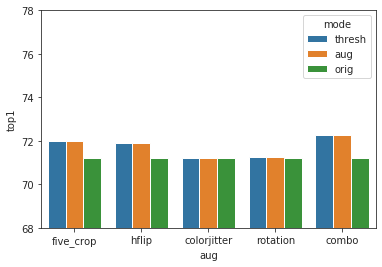

In [18]:
# Thresholding
model_name = 'MobileNetV2'
agg_name = 'partial_lr'
thresholds = pd.read_csv('./results/' + model_name + '_thresholding_' + agg_name)
thresholds
sns.barplot(x='aug', y='top1', hue='mode', data=thresholds, hue_order=['thresh', 'aug', 'orig'])
#plt.ylim(90, 94)
plt.ylim(68, 78)
# maybe subtract out original accuracy?
thresholds

In [9]:
# Anytime augmentation comparison - sampling more brightness or more rotation

In [10]:
# Robustness graph
